##### Imports

In [ ]:
from scripts.embed_extraction import *
from scripts.feature_extraction import fix_encoding
from scripts.plotting import * 

c:\Users\User\anaconda3\envs\deeplearning\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Progress tracking

In [2]:
# track progress
tqdm.pandas()

Check if GPU and CUDA are available/recognized

In [3]:
# cuda version and gpu recognition 
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"CUDA Version: {torch.version.cuda if torch.cuda.is_available() else 'Not available.'}")
print(f"Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

CUDA Available: True
CUDA Version: 12.1
Device: NVIDIA GeForce RTX 3060


### Datasets
- we shuffle the real data, since it has ordering based on authors

In [4]:
## real users data
#df_real = pd.read_csv("../final_data/pandora/PANDORA_full.csv", encoding = "utf-8")

In [5]:
## simulated data
## before moderation
#df_bef = pd.read_csv("../final_data/simulator/exante/before_mod/SIMULATOR_exante_bef_full.csv", encoding = "utf-8")
## ofsa
#df_ofsa = pd.read_csv("../final_data/simulator/exante/after_mod/SIMULATOR_exante_ofsa_full.csv", encoding = "utf-8")
## neutral
#df_neut = pd.read_csv("../final_data/simulator/exante/after_mod/SIMULATOR_exante_neut_full.csv", encoding = "utf-8")
## empathizing
#df_emp = pd.read_csv("../final_data/simulator/exante/after_mod/SIMULATOR_exante_emp_full.csv", encoding = "utf-8")
## prescriptive
#df_pres = pd.read_csv("../final_data/simulator/exante/after_mod/SIMULATOR_exante_pres_full.csv", encoding = "utf-8")

##### Shuffling real data
- to avoid algorithmic bias related to processing order
- only real data, the simulated data has no specific ordering

In [6]:
## shuffle data
#df_real = shuffle(df_real, random_state = SEED).reset_index(drop = True)

##### Test data
- since we need to validate the simulator, we have to sample the real data to have it comparable with the simulated
- we don't base ourselves on the proportions of the specific toxicities obscene, threat, insult and identity attack
    - because we want to look at the differences of exactly these features in real and simulated clusters
    - and we also use them for fine tuning the models
- therefore we use the a binning of the "toxicity" feature, and sample the real data accordingly to its levels in the simulated
- this way, we keep the ratio of general toxic and non-toxic comments as in the simulator, but we don't impact the proportions of the specific toxic features

In [7]:
## toxicity bins and labels
#bins = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
#labels = ["very low", "low", "medium", "high", "very high"]
#
## binning of real and sim data
#df_real["tox_bin"] = pd.cut(df_real["toxicity"], bins = bins, labels = labels, include_lowest = True)
#df_bef["tox_bin"] = pd.cut(df_bef["toxicity"], bins = bins, labels = labels, include_lowest = True)

In [8]:
## distribution of toxicity levels in the simulated data
#bef_tox_dist = df_bef["tox_bin"].value_counts(normalize = True).sort_index()

In [9]:
## num of samples to draw from the real data
#n_samples = 50002 # just to make it 50k
## sample for each level and shuffle
#df_test = pd.concat([df_real[df_real["tox_bin"] == bin_label].sample(n = int(bef_tox_dist[bin_label] * n_samples), replace = False, random_state = SEED)
#    for bin_label in bef_tox_dist.index]).sample(frac = 1, random_state = SEED)

In [10]:
#df_test["tox_bin"].value_counts(normalize = True)

In [11]:
#df_bef["tox_bin"].value_counts(normalize = True)

##### Storing processed datasets

In [12]:
## store real data
#df_real.to_csv("../final_data/pandora/PANDORA.csv", index = False, encoding = "utf-8")
## sample of real data
#df_test.to_csv("../final_data/pandora/PANDORA_test.csv", index = False, encoding = "utf-8")
## store simulated data
#df_bef.to_csv("../final_data/simulator/exante/before_mod/SIMULATOR_exante_bef.csv", index = False, encoding = "utf-8")
#df_ofsa.to_csv("../final_data/simulator/exante/after_mod/SIMULATOR_exante_ofsa.csv", index = False, encoding = "utf-8")
#df_neut.to_csv("../final_data/simulator/exante/after_mod/SIMULATOR_exante_neut.csv", index = False, encoding = "utf-8")
#df_emp.to_csv("../final_data/simulator/exante/after_mod/SIMULATOR_exante_emp.csv", index = False, encoding = "utf-8")
#df_pres.to_csv("../final_data/simulator/exante/after_mod/SIMULATOR_exante_pres.csv", index = False, encoding = "utf-8")

### Datasets
- i only read the comment_id, textual column and toxic features (for fine-tuning) to get the embeddings, in order to reduce memory usage

In [13]:
cols_to_keep = ["comment_id", "llm_body", "obscene", "threat", "insult", "identity_attack"]

##### Real

In [14]:
# real users data
df_real = pd.read_csv("../final_data/pandora/PANDORA.csv", encoding = "utf-8", usecols = cols_to_keep)

In [15]:
df_real.head(3)

,comment_id,llm_body,obscene,threat,insult,identity_attack
0,2691290,i am not going to mason freshman year but i am...,0.000195,0.000112,0.0,0.000140
1,167000,I do not hate it because it is a TLA. I hate i...,0.000729,0.000197,0.0,0.000270
2,1886741,A game I have never heard of is an obvious one...,0.948036,0.002100,0.0,0.002519


##### Simulated

In [16]:
# simulated data before moderation
df_bef = pd.read_csv("../final_data/simulator/exante/before_mod/SIMULATOR_exante_bef.csv", encoding = "utf-8", usecols = cols_to_keep)
# ofsa
df_ofsa = pd.read_csv("../final_data/simulator/exante/after_mod/SIMULATOR_exante_ofsa.csv", encoding = "utf-8", usecols = cols_to_keep)
# neutral
df_neut = pd.read_csv("../final_data/simulator/exante/after_mod/SIMULATOR_exante_neut.csv", encoding = "utf-8", usecols = cols_to_keep)
# empathizing
df_emp = pd.read_csv("../final_data/simulator/exante/after_mod/SIMULATOR_exante_emp.csv", encoding = "utf-8", usecols = cols_to_keep)
# prescriptive
df_pres = pd.read_csv("../final_data/simulator/exante/after_mod/SIMULATOR_exante_pres.csv", encoding = "utf-8", usecols = cols_to_keep)

In [17]:
df_bef.head(3)

,comment_id,llm_body,obscene,threat,insult,identity_attack
0,2,Since I strongly lean towards the republican s...,0.000166,0.000128,0.0,0.000160
1,3,"""Republican is the only way to go! Liberal pol...",0.000633,0.000614,0.0,0.003106
2,4,"As This_Ex_Is_On_Fire, an art enthusiast, I am...",0.002575,0.000449,0.0,0.000502


##### Fix potential erroneous character decodings

In [18]:
fix_encoding(df_real, "llm_body")

100%|██████████| 2710671/2710671 [00:03<00:00, 792821.11it/s]

Text encoding fixed.



In [19]:
fix_encoding(df_bef, "llm_body")
fix_encoding(df_ofsa, "llm_body")
fix_encoding(df_neut, "llm_body")
fix_encoding(df_emp, "llm_body")
fix_encoding(df_pres, "llm_body")

100%|██████████| 3131/3131 [00:00<00:00, 522182.43it/s]


Text encoding fixed.



100%|██████████| 2579/2579 [00:00<00:00, 515985.02it/s]


Text encoding fixed.



100%|██████████| 2620/2620 [00:00<00:00, 654891.33it/s]


Text encoding fixed.



100%|██████████| 2624/2624 [00:00<00:00, 655773.92it/s]


Text encoding fixed.



100%|██████████| 2599/2599 [00:00<00:00, 649603.49it/s]

Text encoding fixed.



### Discretize toxicity for fine-tuning

In [20]:
# bins
bins = [0, 0.33, 0.66, 1]
# labels
labels = ["low", "medium", "high"]

# discretization of toxic features
tox_feat = ["obscene", "threat", "insult", "identity_attack"]

# manual width
for c in tox_feat:
    df_real[c] = pd.cut(df_real[c], bins = bins, labels = labels, right = True, include_lowest = True)

In [21]:
df_real.head()

,comment_id,llm_body,obscene,threat,insult,identity_attack
0,2691290,i am not going to mason freshman year but i am...,low,low,low,low
1,167000,I do not hate it because it is a TLA. I hate i...,low,low,low,low
2,1886741,A game I have never heard of is an obvious one...,high,low,low,low
3,1034242,Oh no. You know I cannot resist a challenge.,low,low,low,low
4,844977,"Hey, you got to be careful when crushing rocks...",low,low,low,low


In [22]:
# shapes
print(f"Shape real: {df_real.shape} Missing values: {df_real['llm_body'].isna().sum()}\n")
print(f"Shape before mod: {df_bef.shape} Missing values: {df_bef['llm_body'].isna().sum()}\n")
print(f"Shape ofsa: {df_ofsa.shape} Missing values: {df_ofsa['llm_body'].isna().sum()}\n")
print(f"Shape neutral: {df_neut.shape} Missing values: {df_neut['llm_body'].isna().sum()}\n")
print(f"Shape empathizing: {df_emp.shape} Missing values: {df_emp['llm_body'].isna().sum()}\n")
print(f"Shape prescriptive: {df_pres.shape} Missing values: {df_pres['llm_body'].isna().sum()}\n")

Shape real: (2710671, 6) Missing values: 0

Shape before mod: (3131, 6) Missing values: 0

Shape ofsa: (2579, 6) Missing values: 0

Shape neutral: (2620, 6) Missing values: 0

Shape empathizing: (2624, 6) Missing values: 0

Shape prescriptive: (2599, 6) Missing values: 0



## Fine-tuning and embeddings extraction
- the main idea is to fine-tune a BERT model for each of the toxicity types, therefore obtaining a multi(four)-headed model
- then, for each comment, we pass it to the each of the heads and we take the last hidden state embedding representations
- we therefore concatenate the STANDARDIZED embeddings, finding the toxicity-based embedding for each of the comments
- we can then perform PCA on the embeddings to find a compressed representation, better suited to perform more efficiently the analyses

In [23]:
# text to process
text_col = "llm_body"

Toxicity classes distribution

In [24]:
for tox in tox_feat:
    print(f"{df_real[tox].value_counts()}\n")

obscene
low       2508006
high       140468
medium      62197
Name: count, dtype: int64

threat
low       2704877
medium       4508
high         1286
Name: count, dtype: int64

insult
low       2706440
high         2142
medium       2089
Name: count, dtype: int64

identity_attack
low       2701619
medium       6762
high         2290
Name: count, dtype: int64



### Fine-Tuning BERTs on toxicity
- some options: bert-base-uncased, distilbert-base-uncased, cardiffnlp/twitter-roberta-base, google/mobilebert-uncased
- we choose bert-base-uncased
- we perform fine-tuning of each bert model on a sample of the real data (max 50k samples), since fine-tuning on all 2.7M comments would be too computationally demanding and also fine-tuning of LLMs doesn't require huge amounts of labelled data
- since there is a huge class imbalance for threat, insult and identity attack, we first somewhat balance the data, undersampling most of the majority class

##### OBSCENE

In [25]:
target = "obscene"

In [ ]:
# datasets for train/val and test
df_obs, df_obs_test = ft_data(df_real, target, imb_ratio = 4, test_size = 0.1)

Processing Obscene data...

Original class distribution: Counter({'low': 2508006, 'high': 140468, 'medium': 62197})
More balanced class distribution: Counter({'low': 248788, 'high': 140468, 'medium': 62197})
Splitting into FT and test set...
Shape of data for FT: (449453, 6)
Shape of the test data: (2000, 6)


In [27]:
# fine-tune a BERT model for each balanced toxic trait
train_loss_obs, val_loss_obs, train_f1_obs, val_f1_obs = finetune_bert(df_obs, text_col, label_col = target, exp_name = target,
                                                                        epochs = 7, lr = 3e-5, dropout = 0.3, n_freeze = 8, batch_size = 32, 
                                                                        sample_size = 20000, val_size = 0.1, stop_early = False, balance = True,
                                                                        bert_variant = "bert-base-uncased")

Original class distribution:
Counter({'low': 247686, 'high': 139846, 'medium': 61921})
Number of labels: 3, Label Mapping: {'high': 0, 'low': 1, 'medium': 2}

Sampling balanced training set...

Training set size: 18000
Training set class distribution:
Counter({1: 6000, 2: 6000, 0: 6000})


Validation set size: 1999
Validation set class distribution:
Counter({1: 1102, 0: 622, 2: 275})


Fine-tuning BERT on Obscene



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Frozen embeddings and first 8 layers, training only the top 4 layers.


Epoch 1/7: 100%|██████████| 563/563 [03:48<00:00,  2.46it/s, loss=0.781]


Epoch 1 - Train Loss: 0.78884, Train F1: 0.60413
Epoch 1 - Val Loss: 0.34555, Val F1: 0.80017



Epoch 2/7: 100%|██████████| 563/563 [03:46<00:00,  2.49it/s, loss=0.449]


Epoch 2 - Train Loss: 0.44234, Train F1: 0.81480
Epoch 2 - Val Loss: 0.31130, Val F1: 0.79907



Epoch 3/7: 100%|██████████| 563/563 [03:45<00:00,  2.49it/s, loss=0.313] 


Epoch 3 - Train Loss: 0.38810, Train F1: 0.84178
Epoch 3 - Val Loss: 0.32026, Val F1: 0.80670



Epoch 4/7: 100%|██████████| 563/563 [03:45<00:00,  2.49it/s, loss=0.35] 


Epoch 4 - Train Loss: 0.36197, Train F1: 0.85014
Epoch 4 - Val Loss: 0.33425, Val F1: 0.78609



Epoch 5/7: 100%|██████████| 563/563 [03:48<00:00,  2.47it/s, loss=0.422]


Epoch 5 - Train Loss: 0.34816, Train F1: 0.85864
Epoch 5 - Val Loss: 0.38601, Val F1: 0.77454



Epoch 6/7: 100%|██████████| 563/563 [03:47<00:00,  2.48it/s, loss=0.398] 


Epoch 6 - Train Loss: 0.33103, Train F1: 0.86560
Epoch 6 - Val Loss: 0.35087, Val F1: 0.79094



Epoch 7/7: 100%|██████████| 563/563 [03:47<00:00,  2.48it/s, loss=0.343] 


Epoch 7 - Train Loss: 0.31711, Train F1: 0.87005
Epoch 7 - Val Loss: 0.33030, Val F1: 0.80166

Fine-tuned model saved for obscene



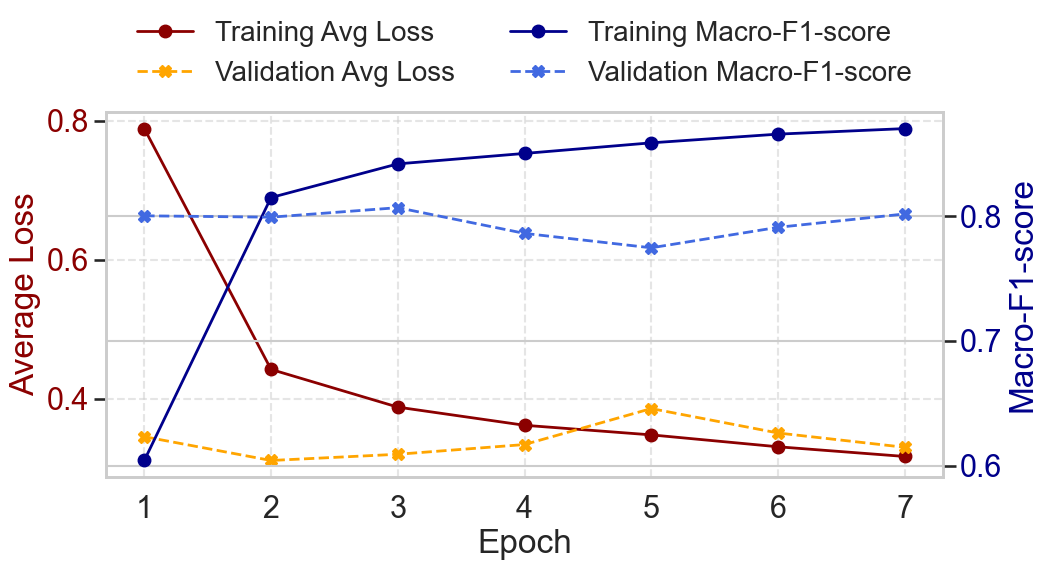

In [114]:
plot_learn_curve(train_loss_obs, val_loss_obs, train_f1_obs, val_f1_obs, target, "F1-score")

In [29]:
# evaluation on test set
test_loss, test_f1 = inference_bert(df_obs_test, text_col, label_col = target, exp_name = target, batch_size = 32)

Number of labels: 3, Label Mapping: {'high': 0, 'low': 1, 'medium': 2}
Test set size: 2000
Test set class distribution:
Counter({1: 1102, 0: 622, 2: 276})

Test Loss: 0.33703, Test F1: 0.78915



##### THREAT

In [30]:
target = "threat"

In [31]:
# datasets for train/val and test
df_thr, df_thr_test = ft_data(df_real, target, imb_ratio = 4, test_size = 0.1)

Processing Threat data...

Original class distribution: Counter({'low': 2704877, 'medium': 4508, 'high': 1286})
More balanced class distribution: Counter({'low': 5144, 'medium': 4508, 'high': 1286})
Splitting into FT and test set...
Shape of data for FT: (9844, 6)
Shape of the test data: (1094, 6)


In [ ]:
# fine-tune a BERT model for each balanced toxic trait
train_loss_thr, val_loss_thr, train_f1_thr, val_f1_thr = finetune_bert(df_thr, text_col, label_col = target, exp_name = target,
                                                                        epochs = 7, lr = 2e-5, dropout = 0.3, n_freeze = 8, batch_size = 32, 
                                                                        sample_size = 20000, val_size = 0.1, stop_early = False, balance = True,
                                                                        bert_variant = "bert-base-uncased")

Original class distribution:
Counter({'low': 4630, 'medium': 4057, 'high': 1157})
Number of labels: 3, Label Mapping: {'high': 0, 'low': 1, 'medium': 2}

Sampling balanced training set...

Training set size: 6947
Training set class distribution:
Counter({1: 2953, 2: 2953, 0: 1041})


Validation set size: 984
Validation set class distribution:
Counter({1: 463, 2: 405, 0: 116})


Fine-tuning BERT on Threat



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Frozen embeddings and first 8 layers, training only the top 4 layers.


Epoch 1/7: 100%|██████████| 218/218 [01:27<00:00,  2.50it/s, loss=0.219]


Epoch 1 - Train Loss: 0.73781, Train F1: 0.49329
Epoch 1 - Val Loss: 0.38856, Val F1: 0.71922



Epoch 2/7: 100%|██████████| 218/218 [01:27<00:00,  2.49it/s, loss=0.119]


Epoch 2 - Train Loss: 0.39509, Train F1: 0.70481
Epoch 2 - Val Loss: 0.37512, Val F1: 0.75155



Epoch 3/7: 100%|██████████| 218/218 [01:29<00:00,  2.45it/s, loss=0.548]


Epoch 3 - Train Loss: 0.36147, Train F1: 0.74746
Epoch 3 - Val Loss: 0.36322, Val F1: 0.76735



Epoch 4/7: 100%|██████████| 218/218 [01:28<00:00,  2.46it/s, loss=0.0437]


Epoch 4 - Train Loss: 0.33152, Train F1: 0.77179
Epoch 4 - Val Loss: 0.35897, Val F1: 0.76425



Epoch 5/7: 100%|██████████| 218/218 [01:28<00:00,  2.47it/s, loss=0.196]


Epoch 5 - Train Loss: 0.31822, Train F1: 0.78072
Epoch 5 - Val Loss: 0.41977, Val F1: 0.74407



Epoch 6/7: 100%|██████████| 218/218 [01:28<00:00,  2.47it/s, loss=0.948]


Epoch 6 - Train Loss: 0.30091, Train F1: 0.79973
Epoch 6 - Val Loss: 0.46432, Val F1: 0.72689



Epoch 7/7: 100%|██████████| 218/218 [01:28<00:00,  2.47it/s, loss=0.453]


Epoch 7 - Train Loss: 0.29656, Train F1: 0.79941
Epoch 7 - Val Loss: 0.42139, Val F1: 0.74556

Fine-tuned model saved for threat



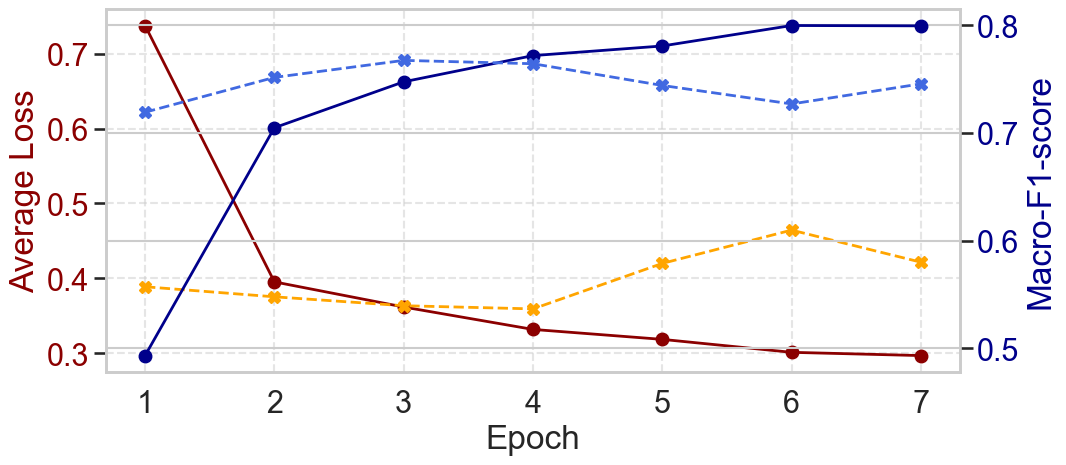

In [116]:
plot_learn_curve(train_loss_thr, val_loss_thr, train_f1_thr, val_f1_thr, target, "F1-score")

In [34]:
# evaluation on test set
test_loss, test_f1 = inference_bert(df_thr_test, text_col, label_col = target, exp_name = target, batch_size = 32)

Number of labels: 3, Label Mapping: {'high': 0, 'low': 1, 'medium': 2}
Test set size: 1094
Test set class distribution:
Counter({1: 514, 2: 451, 0: 129})

Test Loss: 0.37751, Test F1: 0.75781



##### INSULT

In [35]:
target = "insult"

In [36]:
# datasets for train/val and test
df_ins, df_ins_test = ft_data(df_real, target, imb_ratio = 4, test_size = 0.1)

Processing Insult data...

Original class distribution: Counter({'low': 2706440, 'high': 2142, 'medium': 2089})
More balanced class distribution: Counter({'low': 8356, 'high': 2142, 'medium': 2089})
Splitting into FT and test set...
Shape of data for FT: (11328, 6)
Shape of the test data: (1259, 6)


In [ ]:
# fine-tune a BERT model for each balanced toxic trait
train_loss_ins, val_loss_ins, train_f1_ins, val_f1_ins = finetune_bert(df_ins, text_col, label_col = target, exp_name = target,
                                                                        epochs = 7, lr = 4e-5, dropout = 0.3, n_freeze = 8, batch_size = 32, 
                                                                        sample_size = 20000, val_size = 0.1, stop_early = False, balance = True,
                                                                        bert_variant = "bert-base-uncased")

Original class distribution:
Counter({'low': 7520, 'high': 1928, 'medium': 1880})
Number of labels: 3, Label Mapping: {'high': 0, 'low': 1, 'medium': 2}

Sampling balanced training set...

Training set size: 6825
Training set class distribution:
Counter({1: 3398, 0: 1735, 2: 1692})


Validation set size: 1132
Validation set class distribution:
Counter({1: 751, 0: 193, 2: 188})


Fine-tuning BERT on Insult



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Frozen embeddings and first 8 layers, training only the top 4 layers.


Epoch 1/7: 100%|██████████| 214/214 [01:27<00:00,  2.45it/s, loss=0.306]


Epoch 1 - Train Loss: 0.75986, Train F1: 0.58167
Epoch 1 - Val Loss: 0.38520, Val F1: 0.73654



Epoch 2/7: 100%|██████████| 214/214 [01:26<00:00,  2.47it/s, loss=0.196] 


Epoch 2 - Train Loss: 0.29888, Train F1: 0.83832
Epoch 2 - Val Loss: 0.25512, Val F1: 0.82327



Epoch 3/7: 100%|██████████| 214/214 [01:27<00:00,  2.44it/s, loss=0.207] 


Epoch 3 - Train Loss: 0.26176, Train F1: 0.85869
Epoch 3 - Val Loss: 0.14901, Val F1: 0.87577



Epoch 4/7: 100%|██████████| 214/214 [01:27<00:00,  2.44it/s, loss=0.427] 


Epoch 4 - Train Loss: 0.24011, Train F1: 0.86668
Epoch 4 - Val Loss: 0.14117, Val F1: 0.87688



Epoch 5/7: 100%|██████████| 214/214 [01:26<00:00,  2.46it/s, loss=0.35]  


Epoch 5 - Train Loss: 0.22433, Train F1: 0.87734
Epoch 5 - Val Loss: 0.14769, Val F1: 0.88881



Epoch 6/7: 100%|██████████| 214/214 [01:27<00:00,  2.45it/s, loss=0.264] 


Epoch 6 - Train Loss: 0.21123, Train F1: 0.88342
Epoch 6 - Val Loss: 0.14194, Val F1: 0.89011



Epoch 7/7: 100%|██████████| 214/214 [01:27<00:00,  2.45it/s, loss=0.45]  


Epoch 7 - Train Loss: 0.20634, Train F1: 0.88716
Epoch 7 - Val Loss: 0.13888, Val F1: 0.89092

Fine-tuned model saved for insult



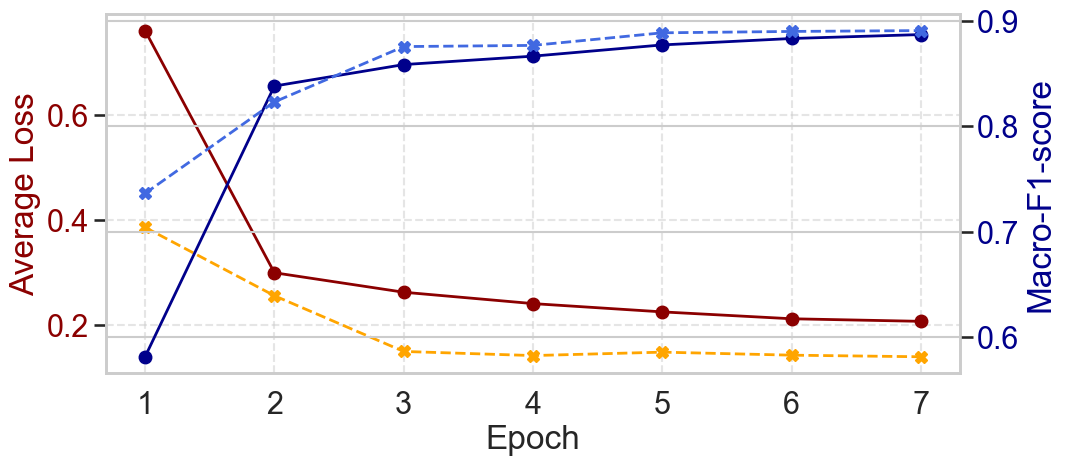

In [117]:
plot_learn_curve(train_loss_ins, val_loss_ins, train_f1_ins, val_f1_ins, target, "F1-score")

In [39]:
# evaluation on test set
test_loss, test_f1 = inference_bert(df_ins_test, text_col, label_col = target, exp_name = target, batch_size = 32)

Number of labels: 3, Label Mapping: {'high': 0, 'low': 1, 'medium': 2}
Test set size: 1259
Test set class distribution:
Counter({1: 836, 0: 214, 2: 209})

Test Loss: 0.14133, Test F1: 0.90103



##### IDENTITY ATTACK

In [40]:
target = "identity_attack"

In [41]:
# datasets for train/val and test
df_idatt, df_idatt_test = ft_data(df_real, target, imb_ratio = 4, test_size = 0.1)

Processing Identity_attack data...

Original class distribution: Counter({'low': 2701619, 'medium': 6762, 'high': 2290})
More balanced class distribution: Counter({'low': 9160, 'medium': 6762, 'high': 2290})
Splitting into FT and test set...
Shape of data for FT: (16390, 6)
Shape of the test data: (1822, 6)


In [42]:
# fine-tune a BERT model for each balanced toxic trait
train_loss_idatt, val_loss_idatt, train_f1_idatt, val_f1_idatt = finetune_bert(df_idatt, text_col, label_col = target, exp_name = target,
                                                                        epochs = 7, lr = 3e-5, dropout = 0.3, n_freeze = 8, batch_size = 32, 
                                                                        sample_size = 20000, val_size = 0.1, stop_early = False, balance = True,
                                                                        bert_variant = "bert-base-uncased")

Original class distribution:
Counter({'low': 8244, 'medium': 6085, 'high': 2061})
Number of labels: 3, Label Mapping: {'high': 0, 'low': 1, 'medium': 2}

Sampling balanced training set...

Training set size: 11689
Training set class distribution:
Counter({1: 4917, 2: 4917, 0: 1855})


Validation set size: 1638
Validation set class distribution:
Counter({1: 824, 2: 608, 0: 206})


Fine-tuning BERT on Identity_attack



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Frozen embeddings and first 8 layers, training only the top 4 layers.


Epoch 1/7: 100%|██████████| 366/366 [02:30<00:00,  2.43it/s, loss=0.493]


Epoch 1 - Train Loss: 0.70374, Train F1: 0.53682
Epoch 1 - Val Loss: 0.37523, Val F1: 0.76359



Epoch 2/7: 100%|██████████| 366/366 [02:29<00:00,  2.46it/s, loss=0.427]


Epoch 2 - Train Loss: 0.39506, Train F1: 0.74944
Epoch 2 - Val Loss: 0.40840, Val F1: 0.76069



Epoch 3/7: 100%|██████████| 366/366 [02:29<00:00,  2.45it/s, loss=0.252] 


Epoch 3 - Train Loss: 0.34885, Train F1: 0.78473
Epoch 3 - Val Loss: 0.34318, Val F1: 0.78406



Epoch 4/7: 100%|██████████| 366/366 [02:30<00:00,  2.42it/s, loss=0.165] 


Epoch 4 - Train Loss: 0.31668, Train F1: 0.80440
Epoch 4 - Val Loss: 0.31422, Val F1: 0.81652



Epoch 5/7: 100%|██████████| 366/366 [02:29<00:00,  2.44it/s, loss=0.0569]


Epoch 5 - Train Loss: 0.30522, Train F1: 0.81716
Epoch 5 - Val Loss: 0.29875, Val F1: 0.82371



Epoch 6/7: 100%|██████████| 366/366 [02:29<00:00,  2.44it/s, loss=0.088] 


Epoch 6 - Train Loss: 0.29385, Train F1: 0.82472
Epoch 6 - Val Loss: 0.35761, Val F1: 0.78437



Epoch 7/7: 100%|██████████| 366/366 [02:31<00:00,  2.41it/s, loss=0.109] 


Epoch 7 - Train Loss: 0.28112, Train F1: 0.82922
Epoch 7 - Val Loss: 0.34708, Val F1: 0.79251

Fine-tuned model saved for identity_attack



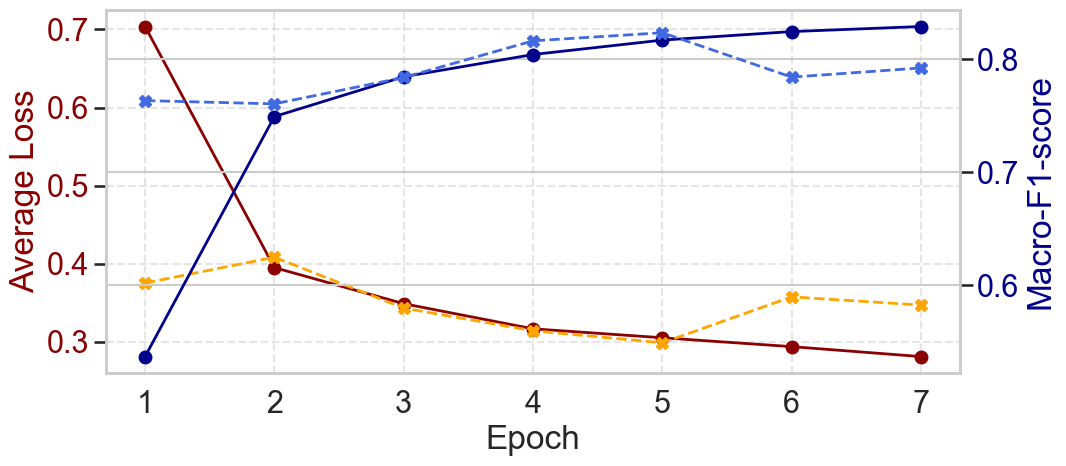

In [118]:
plot_learn_curve(train_loss_idatt, val_loss_idatt, train_f1_idatt, val_f1_idatt, target, "F1-score")

In [44]:
# evaluation on test set
test_loss, test_f1 = inference_bert(df_idatt_test, text_col, label_col = target, exp_name = target, batch_size = 32)

Number of labels: 3, Label Mapping: {'high': 0, 'low': 1, 'medium': 2}
Test set size: 1822
Test set class distribution:
Counter({1: 916, 2: 677, 0: 229})

Test Loss: 0.28942, Test F1: 0.82047



### Embeddings extraction
- with the 2.7M comments it takes at least 80 hours
- also, i have very low frequencies for 3/4 toxicity types, so i need to make sure to select some in the sampled dataset
    - otherwise, by randomly selecting from the original dataset, it would pick only majority classes (low) and some high class for obscene

In [4]:
# toxic traits
tox_feat = ["obscene", "threat", "insult", "identity_attack"]

##### Load sample of real data

In [24]:
df_test = pd.read_csv("../final_data/pandora/PANDORA_test.csv", encoding = "utf-8")
print(f"Shape: {df_test.shape}")
df_test.head(3)

Shape: (50000, 139)


,author,comment_id,llm_body,std_body,gender,age,openness,conscientiousness,extraversion,agreeableness,neuroticism,score,subreddit,id,parent_id,date,time_of_day,num_punct,num_sents,num_words_upp,num_emoji,num_emoji_pos,num_emoji_neg,emoji_unique,emoji_list,fear,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy,polarity,subjectivity,valence,arousal,dominance,flesch,flesch_kincaid,fog,smog,ari,coleman_liau,dale_chall,linsear,difficult_words,num_words,num_words_unique,num_words_adj,num_words_noun,num_words_verb,num_words_lex,num_stopw,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,is_toxic,go,holy fuck,homosexual,say,know,well,bunch,shit,man,racist,would,stupid,also,guy,liberal,make,country,religion,real,crap,right,keep,people,dick,need,asshole,nothing,woman,bitch,one,give,fuck shit,die,black,immigrant,kill,dude,fucking,nigga,suck,take,good,try,idiot,call,insult insult,life,think,society,fuckin,someone,want,stop,see,f cking,way,time,damn,white,fuck,government,get,u,gay,even,death,thing,control,money,muslim,family,hope,really,like,is_real,tox_bin
0,quiteafewfireflies,306083,"Oh, and I have so, so many flaws, haha. They j...",oh many flaw haha mostly affect anyone else,f,32.0,very high,very low,medium,medium,very high,1.0,entp,d1kyxpz,t1_d1kvevw,2016-03-31,21:22:18,5,2,0,0,0,0,,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.425,0.45,0.052826,0.041652,0.050913,87.72,3.3,3.60,0.0,1.9,2.52,6.71,4.00,2.0,18,17,2,4,3,9,10,0.004256,0.000098,0.000337,0.000113,0.0,0.000168,0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,very low
1,Djzongreethesecond,134780,I was going to vote for Rand Paul but I guess ...,go vote rand paul guess not probably trump guess,t,16.0,medium,very low,medium,very low,very high,1.0,entp,d2bdphw,t3_4frij8,2016-04-21,05:39:21,1,1,0,0,0,0,,,0.0,0.1,0.0,0.1,0.3,0.1,0.1,0.1,0.0,0.1,0.000,0.00,0.120190,0.085048,0.094619,86.03,6.0,9.71,0.0,4.7,2.85,7.90,10.50,1.0,20,16,1,8,3,12,11,0.000937,0.000104,0.000168,0.000119,0.0,0.000159,0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,very low
2,goodthankyou,617969,How about walking her home? That is how my ISF...,walk home isfp get know,f,NaN,very low,very low,low,very high,very high,1.0,isfp,ds9w0n9,t3_7nzjky,2018-01-06,14:05:13,3,2,1,1,1,0,:),:),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500,1.00,0.136882,0.065353,0.119412,106.67,0.1,2.80,0.0,-0.9,-0.06,6.24,2.75,1.0,14,13,0,2,4,6,9,0.000925,0.000107,0.000163,0.000127,0.0,0.000144,0,0.0,0.0,0.0,0.0,0.763596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.645695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,very low


Fix encoding

In [25]:
fix_encoding(df_test, "llm_body")

100%|██████████| 50000/50000 [00:00<00:00, 712526.93it/s]

Text encoding fixed.



##### Extraction strategy

In [62]:
# define what strategy to use: [CLS] token or mean pooling of tokens' embs
pooling = "cls" # cls, mean
text_col = "llm_body"

In [63]:
# extract concatenation of text embeddings for each fine-tuned model
real_embs = extract_embeddings(df_test, text_col, traits = tox_feat, pooling = pooling)


Extracting embeddings for Obscene


100%|██████████| 50000/50000 [09:10<00:00, 90.85it/s]



Extracting embeddings for Threat


100%|██████████| 50000/50000 [09:00<00:00, 92.53it/s]



Extracting embeddings for Insult


100%|██████████| 50000/50000 [09:07<00:00, 91.29it/s]



Extracting embeddings for Identity_attack


100%|██████████| 50000/50000 [08:51<00:00, 94.08it/s] 


In [78]:
# extract embeddings for the simulated data
bef_embs = extract_embeddings(df_bef, text_col, traits = tox_feat, pooling = pooling)
ofsa_embs = extract_embeddings(df_ofsa, text_col, traits = tox_feat, pooling = pooling)
neut_embs = extract_embeddings(df_neut, text_col, traits = tox_feat, pooling = pooling)
emp_embs = extract_embeddings(df_emp, text_col, traits = tox_feat, pooling = pooling)
pres_embs = extract_embeddings(df_pres, text_col, traits = tox_feat, pooling = pooling)


Extracting embeddings for Obscene


100%|██████████| 3131/3131 [00:34<00:00, 91.27it/s] 



Extracting embeddings for Threat


100%|██████████| 3131/3131 [00:31<00:00, 98.04it/s] 



Extracting embeddings for Insult


100%|██████████| 3131/3131 [00:31<00:00, 97.87it/s] 



Extracting embeddings for Identity_attack


100%|██████████| 3131/3131 [00:32<00:00, 97.03it/s] 



Extracting embeddings for Obscene


100%|██████████| 2579/2579 [00:26<00:00, 98.21it/s] 



Extracting embeddings for Threat


100%|██████████| 2579/2579 [00:26<00:00, 97.66it/s] 



Extracting embeddings for Insult


100%|██████████| 2579/2579 [00:26<00:00, 97.19it/s] 



Extracting embeddings for Identity_attack


100%|██████████| 2579/2579 [00:26<00:00, 96.87it/s] 



Extracting embeddings for Obscene


100%|██████████| 2620/2620 [00:26<00:00, 98.14it/s] 



Extracting embeddings for Threat


100%|██████████| 2620/2620 [00:26<00:00, 98.02it/s] 



Extracting embeddings for Insult


100%|██████████| 2620/2620 [00:26<00:00, 98.38it/s] 



Extracting embeddings for Identity_attack


100%|██████████| 2620/2620 [00:26<00:00, 98.10it/s] 



Extracting embeddings for Obscene


100%|██████████| 2624/2624 [00:26<00:00, 97.69it/s] 



Extracting embeddings for Threat


100%|██████████| 2624/2624 [00:27<00:00, 95.68it/s] 



Extracting embeddings for Insult


100%|██████████| 2624/2624 [00:26<00:00, 97.65it/s] 



Extracting embeddings for Identity_attack


100%|██████████| 2624/2624 [00:27<00:00, 96.59it/s] 



Extracting embeddings for Obscene


100%|██████████| 2599/2599 [00:26<00:00, 97.94it/s] 



Extracting embeddings for Threat


100%|██████████| 2599/2599 [00:26<00:00, 97.75it/s] 



Extracting embeddings for Insult


100%|██████████| 2599/2599 [00:26<00:00, 97.15it/s] 



Extracting embeddings for Identity_attack


100%|██████████| 2599/2599 [00:26<00:00, 97.79it/s] 


In [64]:
# real
print(f"Shape real: {real_embs.shape}")

Shape real: (50000, 3072)


In [ ]:
# simulated
print(f"Shape before: {bef_embs.shape}")
print(f"Shape ofsa: {ofsa_embs.shape}")
print(f"Shape neutral: {neut_embs.shape}")
print(f"Shape empathizing: {emp_embs.shape}")
print(f"Shape prescriptive: {pres_embs.shape}")

Shape real: (11761, 3072)
Shape before: (3131, 3072)
Shape ofsa: (2579, 3072)
Shape neutral: (2620, 3072)
Shape empathizing: (2624, 3072)
Shape prescriptive: (2599, 3072)


##### Store complete embeddings

In [ ]:
## real data embeddings
#np.save(f"../final_data/pandora/embeddings_tox/PANDORA_test_embs_3072_{pooling}.npy", real_embs)
#
## simulator ex-ante embeddings
## before moderation
#np.save(f"../final_data/simulator/exante/before_mod/embeddings_tox/SIMULATOR_exante_bef_embs_3072_{pooling}.npy", bef_embs)
## after moderation
#np.save(f"../final_data/simulator/exante/after_mod/embeddings_tox/SIMULATOR_exante_ofsa_embs_3072_{pooling}.npy", ofsa_embs)
#np.save(f"../final_data/simulator/exante/after_mod/embeddings_tox/SIMULATOR_exante_neut_embs_3072_{pooling}.npy", neut_embs)
#np.save(f"../final_data/simulator/exante/after_mod/embeddings_tox/SIMULATOR_exante_emp_embs_3072_{pooling}.npy", emp_embs)
#np.save(f"../final_data/simulator/exante/after_mod/embeddings_tox/SIMULATOR_exante_pres_embs_3072_{pooling}.npy", pres_embs)

##### Load embeddings

In [5]:
pooling = "cls" # cls, mean

In [6]:
# real data embeddings
real_embs = np.load(f"../final_data/pandora/embeddings_tox/PANDORA_test_embs_3072_{pooling}.npy")

# simulator ex-ante embeddings
# before moderation
bef_embs = np.load(f"../final_data/simulator/exante/before_mod/embeddings_tox/SIMULATOR_exante_bef_embs_3072_{pooling}.npy")
# after moderation
ofsa_embs = np.load(f"../final_data/simulator/exante/after_mod/embeddings_tox/SIMULATOR_exante_ofsa_embs_3072_{pooling}.npy")
neut_embs = np.load(f"../final_data/simulator/exante/after_mod/embeddings_tox/SIMULATOR_exante_neut_embs_3072_{pooling}.npy")
emp_embs = np.load(f"../final_data/simulator/exante/after_mod/embeddings_tox/SIMULATOR_exante_emp_embs_3072_{pooling}.npy")
pres_embs = np.load(f"../final_data/simulator/exante/after_mod/embeddings_tox/SIMULATOR_exante_pres_embs_3072_{pooling}.npy")

##### Standardization of embeddings

In [7]:
real_embs_std, scaler = zscore_scale(real_embs)

In [8]:
bef_embs_std = scaler.transform(bef_embs)
ofsa_embs_std = scaler.transform(ofsa_embs)
neut_embs_std = scaler.transform(neut_embs)
emp_embs_std = scaler.transform(emp_embs)
pres_embs_std = scaler.transform(pres_embs)

### Embeddings compression with PCA
- the idea is to first remove noise by using PCA, retaining at least 90% of embeddings' variance
- therefore apply clustering on the reduced space to find toxic profiles
- the PCA is fitted exclusively on the real data
- we then transform all the embeddings accordingly, since the real data represents the actual personality-related language

##### PCA

Shape before PCA: (50000, 3072)
Shape after PCA: (50000, 357)


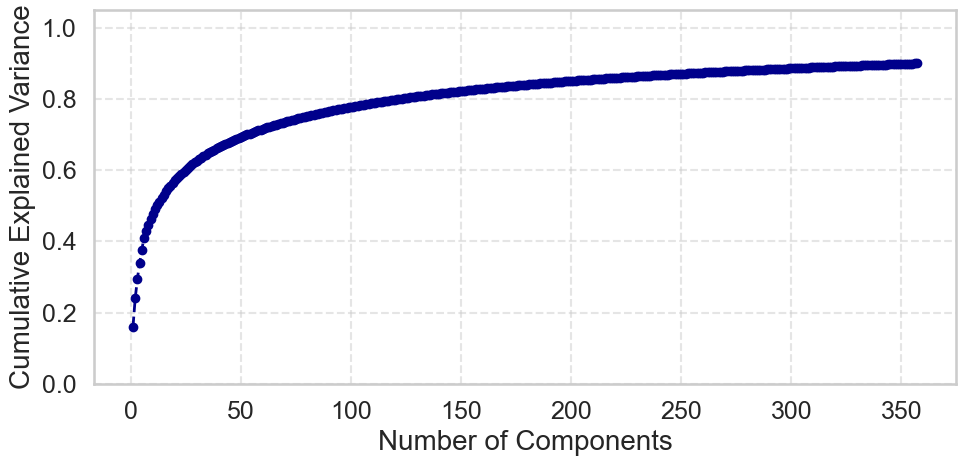

In [37]:
real_embs_pca, fitted_pca = apply_pca(real_embs_std, explain_perc = 0.9)

In [54]:
bef_embs_pca = fitted_pca.transform(bef_embs_std)
ofsa_embs_pca = fitted_pca.transform(ofsa_embs_std)
neut_embs_pca = fitted_pca.transform(neut_embs_std)
emp_embs_pca = fitted_pca.transform(emp_embs_std)
pres_embs_pca = fitted_pca.transform(pres_embs_std)

##### Add comment ID to embeddings (for future cross-analyses)

In [46]:
real_embs_pca = add_comment_id(df_test, real_embs_pca)
bef_embs_pca = add_comment_id(df_bef, bef_embs_pca)
ofsa_embs_pca = add_comment_id(df_ofsa, ofsa_embs_pca)
neut_embs_pca = add_comment_id(df_neut, neut_embs_pca)
emp_embs_pca = add_comment_id(df_emp, emp_embs_pca)
pres_embs_pca = add_comment_id(df_pres, pres_embs_pca)

##### Store compressed embeddings

In [47]:
# real data
np.save(f"../final_data/pandora/embeddings_tox/{pooling}/PANDORA_test_embs_{real_embs_pca.shape[1]-1}.npy", real_embs_pca)

In [48]:
# before mod
np.save(f"../final_data/simulator/exante/before_mod/embeddings_tox/{pooling}/SIMULATOR_exante_bef_embs_{bef_embs_pca.shape[1]-1}.npy", bef_embs_pca)
# after mod
np.save(f"../final_data/simulator/exante/after_mod/embeddings_tox/{pooling}/SIMULATOR_exante_ofsa_embs_{ofsa_embs_pca.shape[1]-1}.npy", ofsa_embs_pca)
np.save(f"../final_data/simulator/exante/after_mod/embeddings_tox/{pooling}/SIMULATOR_exante_neut_embs_{neut_embs_pca.shape[1]-1}.npy", neut_embs_pca)
np.save(f"../final_data/simulator/exante/after_mod/embeddings_tox/{pooling}/SIMULATOR_exante_emp_embs_{emp_embs_pca.shape[1]-1}.npy", emp_embs_pca)
np.save(f"../final_data/simulator/exante/after_mod/embeddings_tox/{pooling}/SIMULATOR_exante_pres_embs_{pres_embs_pca.shape[1]-1}.npy", pres_embs_pca)